In [ ]:
import scipy
import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import sys
sys.path.append("../")

from models import RNNGC
from dataset import DatasetMaker

In [ ]:
def population_decoding(g, memory, r_memory):
    """Population decoding scheme: decode location as location r_memory 
       corresponding to most similar (closest) population vector in memory
       to current population vector p

    Args:
        g (N, n_g): population vectors to be decoded
        memory (M, n_g): memory of population vectors
        r_memory (M, 2): physical locations of memory vectors
    """
    dists = np.sum((g[None] - memory[:,None])**2, axis = -1) # (M, N)
    inds = np.argmin(dists, axis = 0) # (N)
    decoded_trajectories = r_memory[inds] #(N, 2)
    return decoded_trajectories

def decode_idw2(g, memory, r_memory, p = 2):
    # inverse distance weight for interpolation
    eps = 1e-16
    diff = memory[None] - g[:,None]
    dist = np.sum(diff**p, axis = -1)
    dist[dist == 0] = eps # hack away zero division
    w = 1/dist 
    # decoded position is weighted average
    v = np.sum(r_memory[None]*w[...,None], axis = -2) / np.sum(w, axis = -1, keepdims = True)    
    return v


In [3]:
# instantiate RNN model
model = RNNGC()
model = model.load("../saved-models/RNNGC_49999.pkl")

In [4]:
dataset = DatasetMaker()

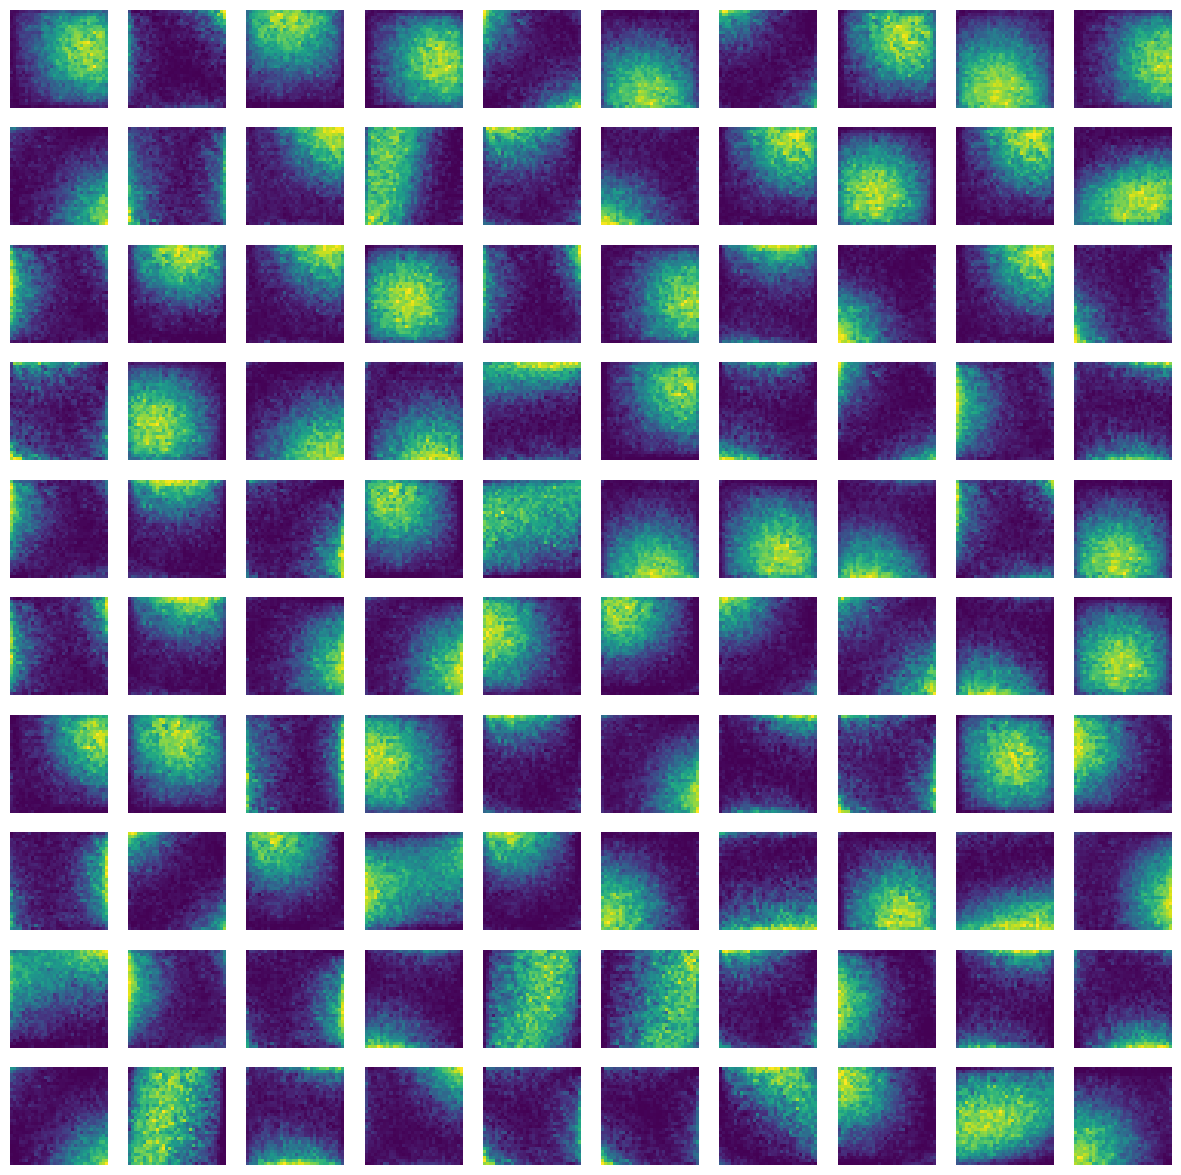

In [ ]:
# visualize representations
n_plot = 5000 # number of plot trajectories
n_show = 100 # number of units to show
timesteps = 10
res = 16 # ratemap + memory resolution

r, v = dataset.generate_data(n_plot, timesteps)

# 'ere we go again
g = model((r[:,0], v))
g = g.detach().numpy()
rs = r.detach().numpy().reshape(-1, 2)

ratemaps, x, y, _ = scipy.stats.binned_statistic_2d(rs[...,0], rs[...,1], g.reshape(-1, g.shape[-1]).T, bins = res)

ns = 10 # ns x ns grid of unit ratemaps
count = 0
fig, ax = plt.subplots(ns,ns, figsize = (15,15))
for i in range(ns):
    for j in range(ns):
        im = ax[i,j].imshow(ratemaps[count])
        ax[i,j].axis("off")
        count += 1

/var/folders/rv/mky69fln76nbwl7qkb06318h0000gn/T/ipykernel_25125/2042740478.py:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.sum(dist**2, axis = 0)))


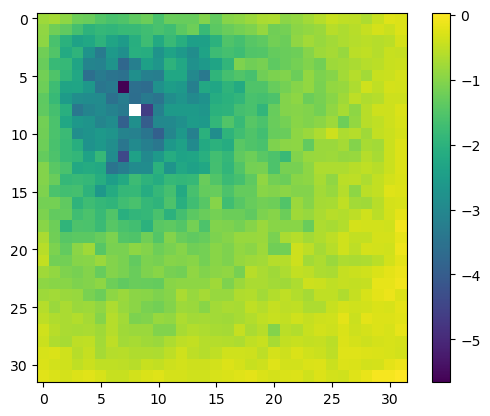

In [6]:
dist = ratemaps - ratemaps[:, 8, 8, None, None]
plt.imshow(np.log(np.sum(dist**2, axis = 0)))
ratemaps.shape
plt.colorbar()

In [7]:
# Form "memory" of population vectors: just use ratemaps
print(ratemaps.shape, model.ng)
memory = g.reshape(-1, g.shape[-1])#ratemaps.reshape(model.ng,-1).T

(256, 32, 32) 256


In [8]:
xx = x[:-1] + np.diff(x)/2 # midpoint of bins used for ratemaps
yy = y[:-1] + np.diff(y)/2
xx, yy = np.meshgrid(xx,yy)
r_memory = rs#np.stack((yy.ravel(), xx.ravel()), axis =-1) # (square) grid of memory locations

In [9]:
memory.shape, r_memory.shape

((50000, 256), (50000, 2))

In [15]:
# evaluate on unseen trajectories
n_eval = 10
t_eval = 8
r_eval, v_eval = dataset.generate_data(n_eval, t_eval)
r_eval = r_eval*0.2
g_eval = model((r_eval[:,0], v_eval))  
g_eval = g_eval.detach().numpy()


In [16]:
r_decoded = population_decoding(g_eval.reshape(-1, g_eval.shape[-1]), memory, r_memory) # beware, this is N^2 :O
# r_decoded = decode_idw2(g_eval.reshape(-1, g_eval.shape[-1]), memory, r_memory, 100) # beware, this is N^2 :O
print(r_decoded)
r_decoded = r_decoded.reshape(g_eval.shape[0], g_eval.shape[1], 2) # 
r_decoded.shape

[[ 0.4515863  -1.0352799 ]
 [ 0.38960022 -1.1413049 ]
 [ 0.5849194  -0.865139  ]
 [ 0.07983366 -1.1740731 ]
 [ 0.58721346 -1.1368603 ]
 [ 0.75118285 -0.93301004]
 [ 0.38937378 -1.1057059 ]
 [ 0.00844256 -1.1197094 ]
 [ 0.23680237 -0.99843466]
 [ 0.21945778 -0.94475746]
 [ 0.33905667 -0.65012884]
 [ 0.62457556 -0.68751895]
 [ 0.6995835  -1.095666  ]
 [ 0.6599212  -1.1088895 ]
 [-0.3784197  -1.1914314 ]
 [-0.33736557 -1.1153132 ]
 [ 0.07319536  0.4379494 ]
 [ 0.05455066  0.38779435]
 [-0.06879006  0.63354605]
 [-0.00689922  0.20531753]
 [ 0.5753186   0.4933934 ]
 [ 0.22791551 -0.02681932]
 [-0.20319477  0.07275443]
 [ 0.5191056   0.2076129 ]
 [ 1.1091514  -0.44179907]
 [ 1.0323958  -0.45502615]
 [ 0.866002   -0.7586651 ]
 [ 0.84468585 -0.6667308 ]
 [ 0.60265476 -0.7109419 ]
 [ 1.0178355  -0.14924072]
 [ 1.0186793  -0.22562619]
 [ 0.8680237   0.28764996]
 [ 1.1835454   0.881633  ]
 [ 1.1428517   0.8732444 ]
 [ 1.0768462   0.6503491 ]
 [ 0.72190154  0.9843094 ]
 [ 0.72712046  0.96257335]
 

(10, 8, 2)

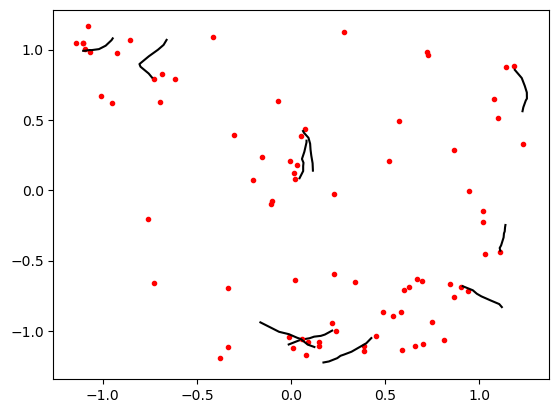

In [17]:
# plot some examples
for i in range(10):
    plt.plot(r_decoded[i,:, 0], r_decoded[i,:,1], ".r")
    plt.plot(r_eval[i,:, 0], r_eval[i,:,1], "k")
# plt.axis([-1, 1, -1, 1])

Text(0, 0.5, 'Decoding Error')

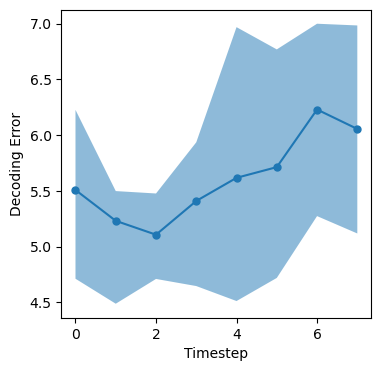

In [13]:
plt.figure(figsize=(4,4))

error = np.linalg.norm(r_eval - r_decoded, axis = -1)

error_quartiles = np.percentile(error, [25, 75], axis = 0)
plt.plot(np.mean(error, axis = 0),"-o", markersize = 5, label = "Population" )
plt.fill_between(np.arange(t_eval), error_quartiles[0], error_quartiles[1], alpha = 0.5)

plt.xlabel("Timestep")
plt.ylabel("Decoding Error")

(32, 32)


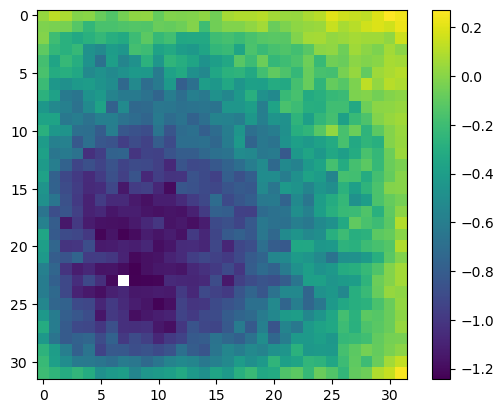

(32, 32)


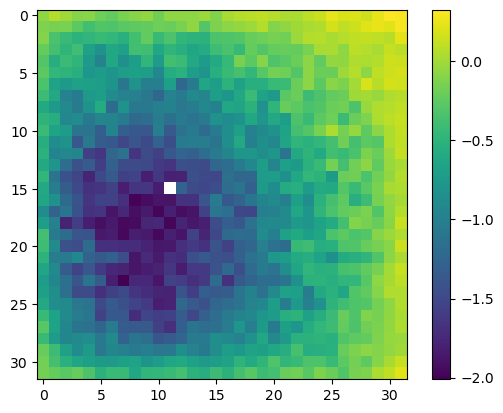

(32, 32)


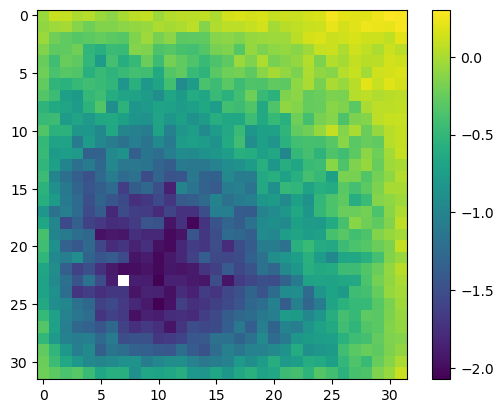

(32, 32)


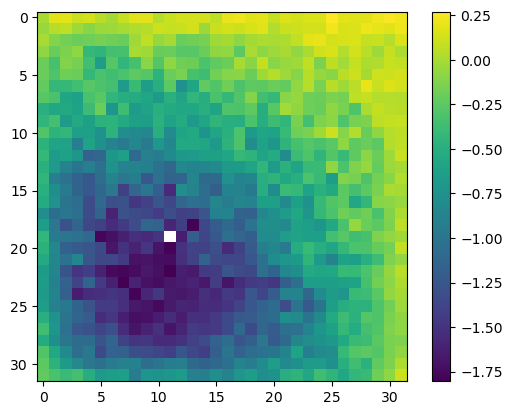

(32, 32)


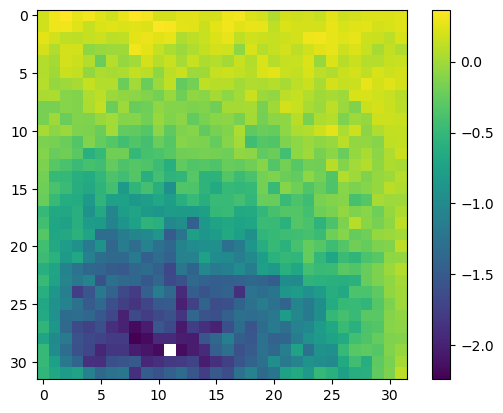

(32, 32)


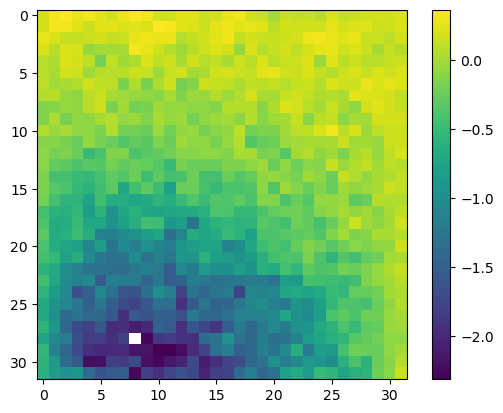

(32, 32)


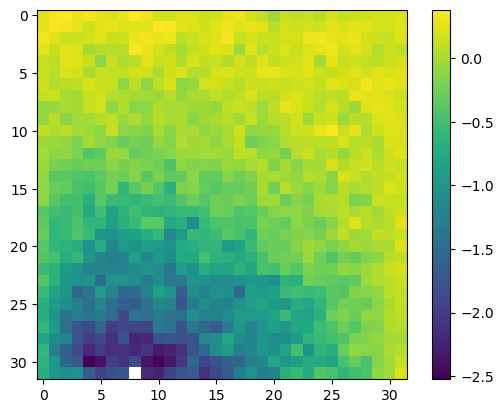

(32, 32)


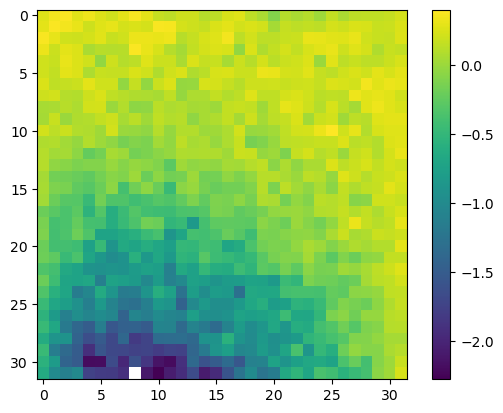

IndexError: index 8 is out of bounds for axis 1 with size 8

In [ ]:
for i in range(10):
    dist = np.sum((ratemaps - g_eval[0, i].T[:,None, None])**2,axis=-0)
    print(dist.shape)
    dist.ravel()[np.argmin(dist.ravel())] = np.nan
    plt.imshow(np.log(dist))
    plt.plot()
    ratemaps.shape
    plt.colorbar()
    plt.show()